# Dependency Tree as DisCoPy Diagram

In [1]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

In [2]:
doc = nlp("If you like recursion, read this sentence.")
displacy.render(doc, style="dep")

# [Navigating the parse tree](https://spacy.io/usage/linguistic-features#navigating)

`dependency_tree` recursively builds a diagram from dependency tree inferred by spaCy.

- **Objects/Wires:** a tuple of (part-of-speech, dependency)
    - the 'recursion' box/morphism, for example, spits out a **(NOUN, dobj)**. In other words, the (categorical) object is **'nouns acting as a direct object'**.

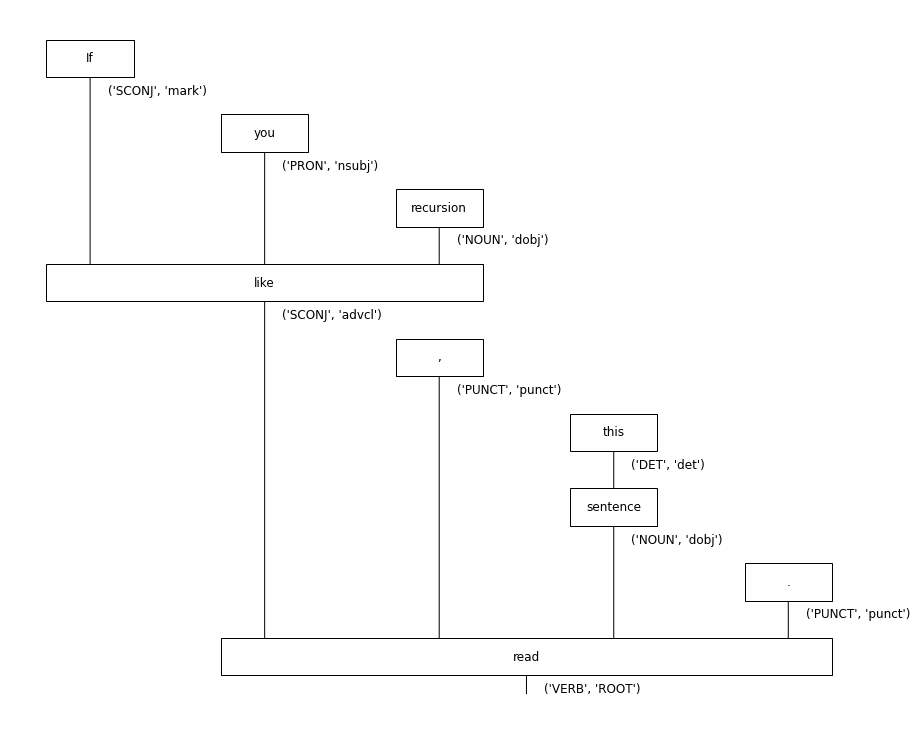

In [3]:
from discopy import Box, Ty

def dependency_tree(token):
    """
    Given a token, recursively builds a dependency diagram from its
    dependent subtree.
    """
    
    # codomain is easy... just the token.dep_
    cod = Ty((token.pos_, token.dep_))
    
    # base case
    # token.children returns a generator
    if token.n_lefts + token.n_rights == 0:
        return Box(token.text, Ty(), cod)
    
    else:
        # codomain starts as empty type
        dom = Ty()
        
        subdiagram = None
        for child in token.children:
            # build domain from dependent children
            dom = dom @ Ty((child.pos_, child.dep_))
            # build subdiagrams recursively and take tensor product
            if subdiagram is not None: subdiagram = subdiagram @ dependency_tree(child)
            else: subdiagram = dependency_tree(child)

        return subdiagram >> Box(token.text, dom, cod)


sentences = [s for s in doc.sents]
R = sentences[0].root
dependency_tree(R).draw(figsize=(12,10))

### I removed punctuation here because it made the diagrams look nicer
...but if spaCy has a 'PUNCT' part-of-speech tag and a 'punct' dependency tag, should these be considered? Perhaps we only need to discard them if/when these diagrams are mapped to another category?

Input text: If you like recursion, read this sentence.
Output diagrams:


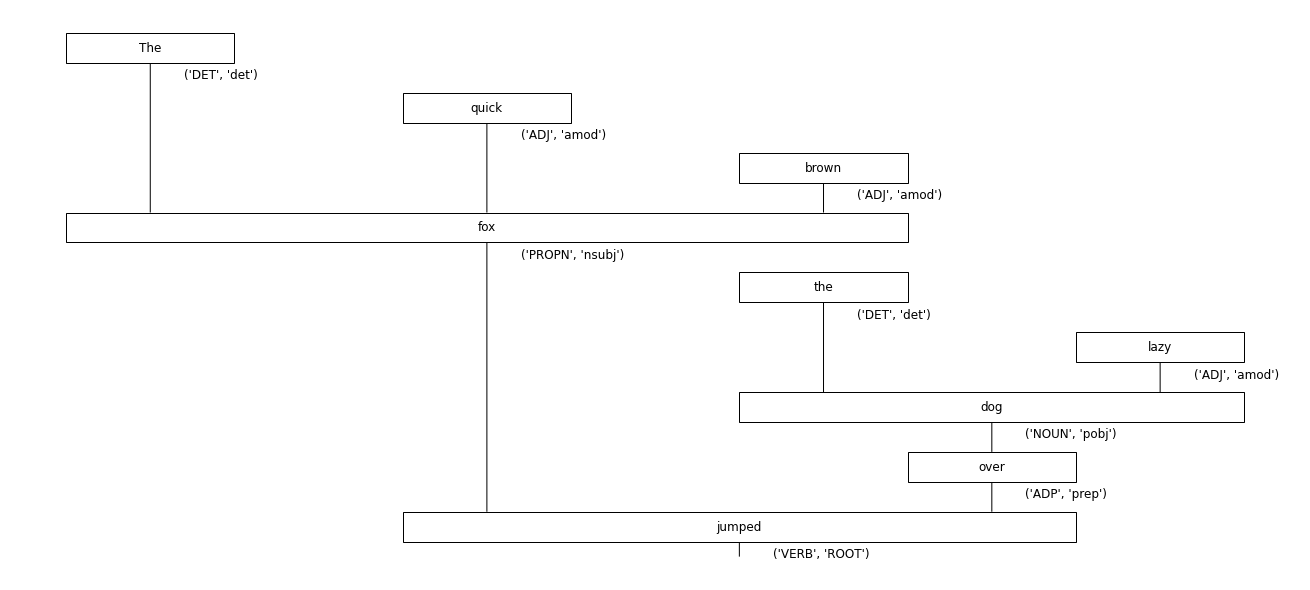

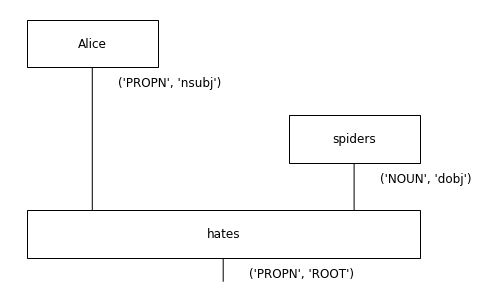

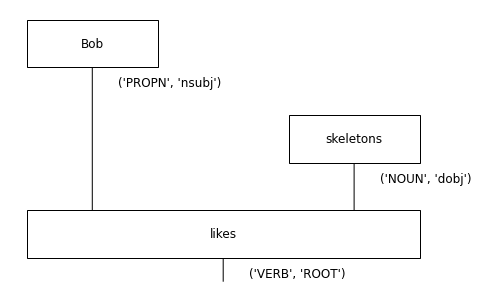

In [4]:
def dependency_forest(doc, remove_punct=False):
    """
    Splits a document into sentences, creates a dependency diagram for each sentence.
    Drops punctuation if remove_punct=True.
    """
    
    # split sentences
    sentences = [s for s in doc.sents]
    
    # remove punctuation?
    if remove_punct:
        sentences = [[x for x in nlp(' '.join([t.text for t in s if t.pos != spacy.symbols.PUNCT]))\
                     .sents][0]
                     for s in doc.sents]
    
    # get diagrams for each sentence
    diagrams = [dependency_tree(s.root) for s in sentences]
    
    return diagrams

doc2 = nlp("The quick brown fox jumped over the lazy dog. Alice hates spiders. Bob likes skeletons.")
diagrams = dependency_forest(doc2, remove_punct=True)
print(f"Input text: {doc}\nOutput diagrams:")
diagrams[0].draw(figsize=(18,8))
diagrams[1].draw()
diagrams[2].draw()

# Three sentences, three semantic outputs

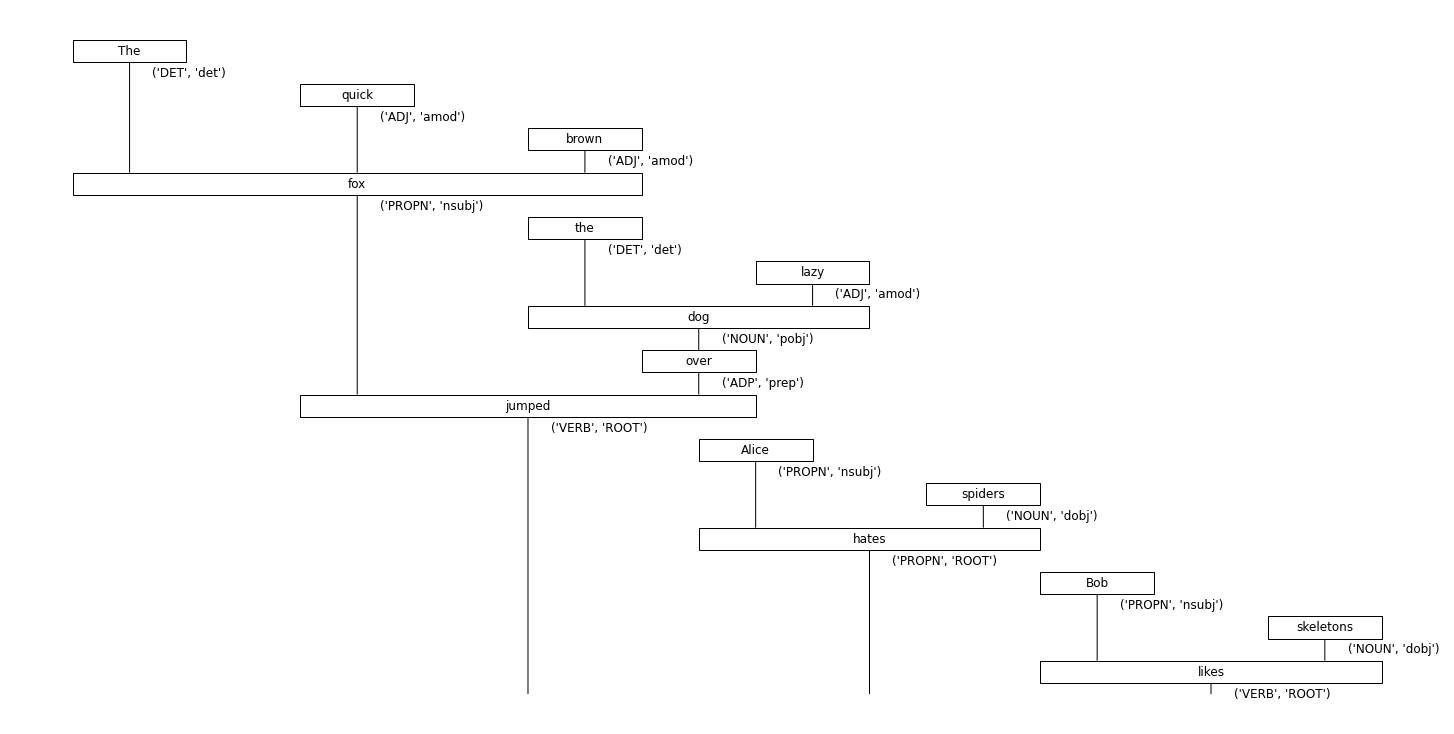

In [5]:
import functools
functools.reduce(lambda x,y: x@y, diagrams).normal_form().draw(figsize=(20,10))

In [6]:
displacy.render(doc2, style='dep')